In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch.nn.functional as F


In [2]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4234, 0.4089, 0.3468], std=[0.2358, 0.2295, 0.2207])
    ])

In [3]:
data_dir='test/'

In [5]:
test_data = datasets.ImageFolder(f'{data_dir}', transform=test_transform)

In [8]:
birds=list(test_data.class_to_idx.keys())

In [9]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [11]:
output_len= len(birds)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3, 64, 3, 1,1 ) # OP 224
        self.conv2=nn.Conv2d(64, 128, 3, 1,1 ) # OP 224
        self.conv3=nn.Conv2d(128, 256, 3, 1,1 ) # OP 224
        self.conv4=nn.Conv2d(256, 512, 3, 1,1 ) # OP 224
        self.conv5=nn.Conv2d(512, 1024, 3, 1,1 ) # OP 224
        self.conv6=nn.Conv2d(1024, 2048, 3, 1,1 ) # OP 224
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_len)
        
        self.bc1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc5 = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc6 = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        
        self.dropout=nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bc1(self.conv1(x))))
        x = self.pool(F.relu(self.bc2(self.conv2(x))))
        x = self.pool(F.relu(self.bc3(self.conv3(x))))
        x = self.pool(F.relu(self.bc4(self.conv4(x))))
        x = self.pool(F.relu(self.bc5(self.conv5(x))))
#         x = self.pool(F.relu(self.bc6(self.conv6(x))))
        
        # flatten the tensor
        x=self.avg(x)
        x = x.view(x.size(0), -1)
        
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=F.log_softmax(self.fc3(x), dim=1)
        
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=525, bias=True)
  (bc1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [14]:
save_model='bird_model_best.pt'
state_dict = torch.load(save_model, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


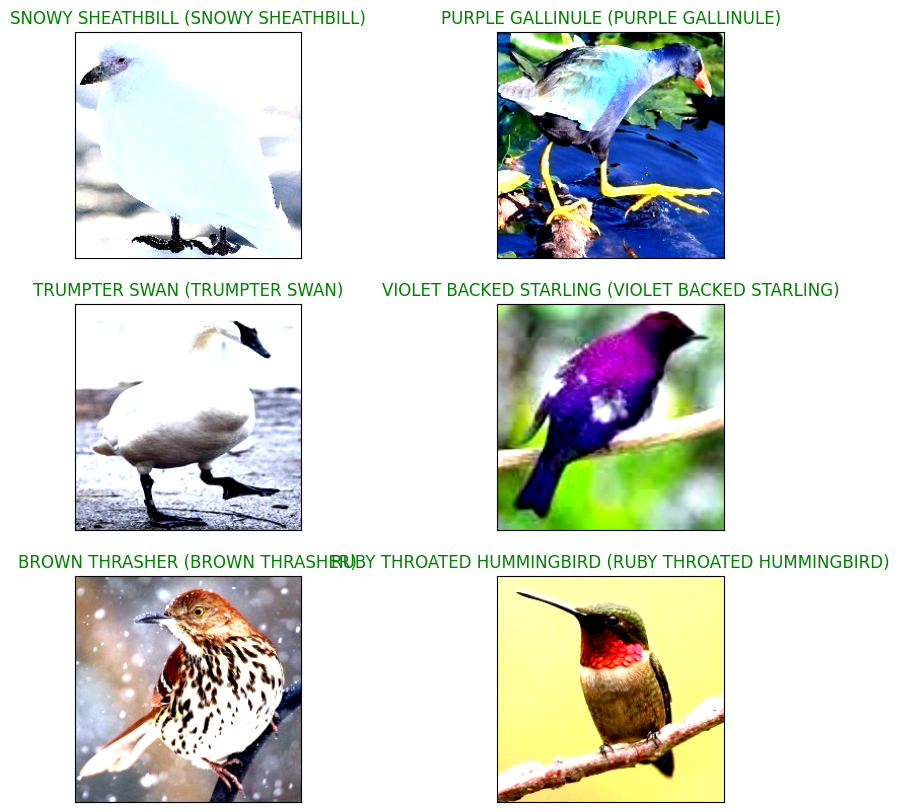

In [31]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images.numpy()


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(6):
    ax = fig.add_subplot(3, int(4/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(birds[preds[idx]], birds[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))